In [2]:
# checking for tensorflow devices
from tensorflow.python.client import device_lib
for d in device_lib.list_local_devices():
    print(d.name, d.physical_device_desc)

/device:CPU:0 
/device:GPU:0 device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1b.0, compute capability: 7.0
/device:GPU:1 device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1c.0, compute capability: 7.0
/device:GPU:2 device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1d.0, compute capability: 7.0
/device:GPU:3 device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0


In [22]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import optimizers
import keras.backend as K
from keras.utils import to_categorical, multi_gpu_model
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import load_iris
from keras.datasets import fashion_mnist, mnist, cifar100
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.applications.vgg16 import VGG16, decode_predictions

np.set_printoptions(suppress=True)
%matplotlib inline

In [4]:
# dataset generators for test and train
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# dataset generators for test and train
train_generator = train_datagen.flow_from_directory(
        'kaggle/dogs-vs-cats/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        'kaggle/dogs-vs-cats/validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [6]:
# all images are scaled to the same size
input_shape = (224, 224, 3)

In [7]:
vgg = VGG16(weights='imagenet', input_shape=input_shape)

In [8]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
batch = validation_generator.next()
predictions = vgg.predict(batch[0])

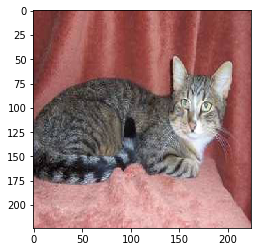

[[('n03788365', 'mosquito_net', 0.10852751), ('n15075141', 'toilet_tissue', 0.029112045), ('n04209239', 'shower_curtain', 0.02219359)]]


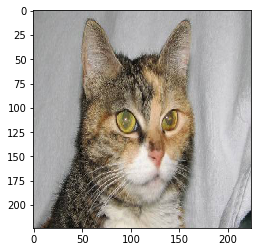

[[('n03788365', 'mosquito_net', 0.16808575), ('n04209239', 'shower_curtain', 0.06415511), ('n15075141', 'toilet_tissue', 0.04686114)]]


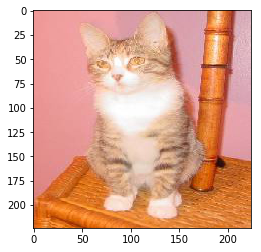

[[('n03788365', 'mosquito_net', 0.18671845), ('n15075141', 'toilet_tissue', 0.03388095), ('n04209239', 'shower_curtain', 0.03265706)]]


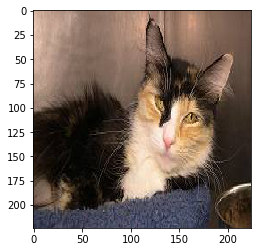

[[('n03788365', 'mosquito_net', 0.082906745), ('n15075141', 'toilet_tissue', 0.021860449), ('n04209239', 'shower_curtain', 0.020339685)]]


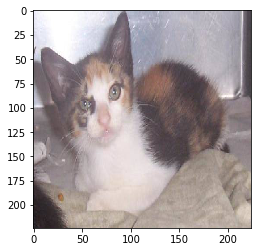

[[('n03788365', 'mosquito_net', 0.10019646), ('n04209239', 'shower_curtain', 0.042724907), ('n15075141', 'toilet_tissue', 0.032481458)]]


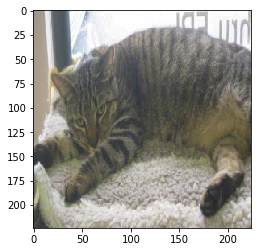

[[('n03788365', 'mosquito_net', 0.12936509), ('n15075141', 'toilet_tissue', 0.034921262), ('n04209239', 'shower_curtain', 0.021528877)]]


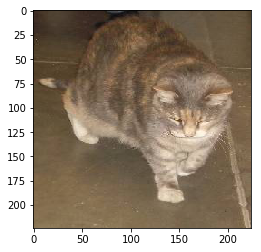

[[('n03788365', 'mosquito_net', 0.07721453), ('n15075141', 'toilet_tissue', 0.041771226), ('n04209239', 'shower_curtain', 0.021059029)]]


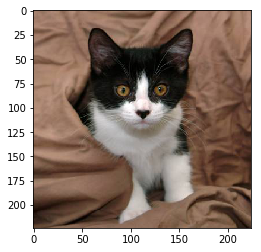

[[('n03788365', 'mosquito_net', 0.19992553), ('n15075141', 'toilet_tissue', 0.06246183), ('n03887697', 'paper_towel', 0.028446503)]]


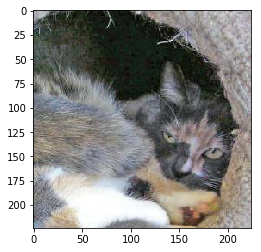

[[('n03788365', 'mosquito_net', 0.075189985), ('n02111889', 'Samoyed', 0.0338242), ('n02120079', 'Arctic_fox', 0.027539806)]]


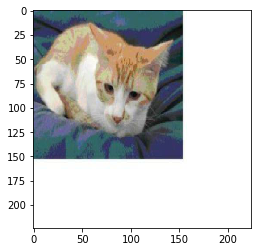

[[('n03788365', 'mosquito_net', 0.070064984), ('n15075141', 'toilet_tissue', 0.06908982), ('n03291819', 'envelope', 0.03448752)]]


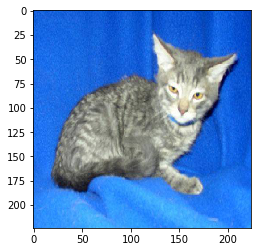

[[('n03788365', 'mosquito_net', 0.07327445), ('n15075141', 'toilet_tissue', 0.040926013), ('n03887697', 'paper_towel', 0.016553469)]]


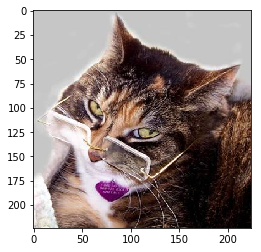

[[('n03788365', 'mosquito_net', 0.14867471), ('n15075141', 'toilet_tissue', 0.038887743), ('n04209239', 'shower_curtain', 0.033364832)]]


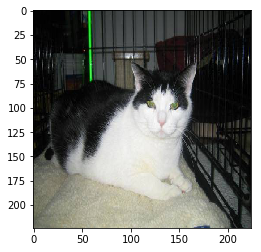

[[('n03788365', 'mosquito_net', 0.14429294), ('n04209239', 'shower_curtain', 0.03167637), ('n15075141', 'toilet_tissue', 0.026944334)]]


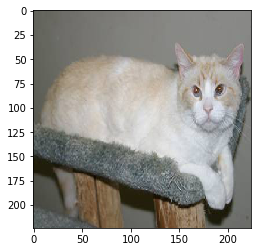

[[('n03788365', 'mosquito_net', 0.09417833), ('n15075141', 'toilet_tissue', 0.03479622), ('n04209239', 'shower_curtain', 0.02474702)]]


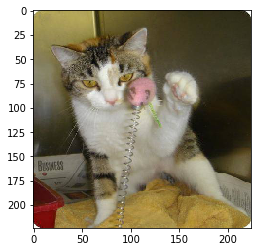

[[('n03788365', 'mosquito_net', 0.16928259), ('n15075141', 'toilet_tissue', 0.04210087), ('n04209239', 'shower_curtain', 0.035092477)]]


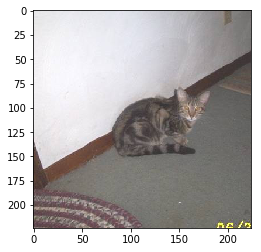

[[('n03788365', 'mosquito_net', 0.12107491), ('n15075141', 'toilet_tissue', 0.02617833), ('n03291819', 'envelope', 0.01724549)]]


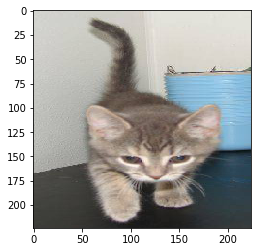

[[('n03788365', 'mosquito_net', 0.11547356), ('n15075141', 'toilet_tissue', 0.0506641), ('n03887697', 'paper_towel', 0.019548992)]]


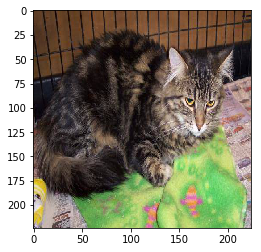

[[('n03788365', 'mosquito_net', 0.21456471), ('n15075141', 'toilet_tissue', 0.03759115), ('n04209239', 'shower_curtain', 0.029807603)]]


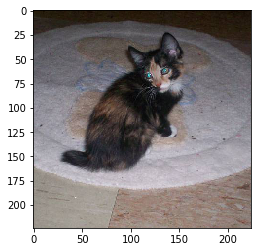

[[('n03788365', 'mosquito_net', 0.07795281), ('n15075141', 'toilet_tissue', 0.045364134), ('n03887697', 'paper_towel', 0.016350193)]]


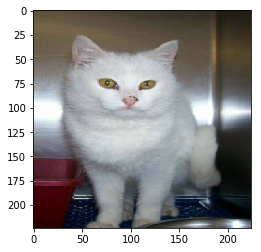

[[('n03788365', 'mosquito_net', 0.12019854), ('n04209239', 'shower_curtain', 0.040349916), ('n15075141', 'toilet_tissue', 0.039301462)]]


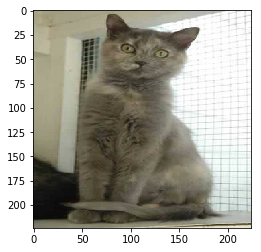

[[('n03788365', 'mosquito_net', 0.11310022), ('n15075141', 'toilet_tissue', 0.031703938), ('n04209239', 'shower_curtain', 0.019993039)]]


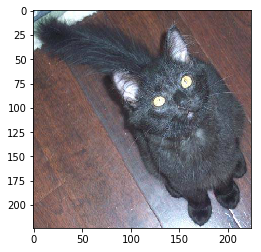

[[('n03788365', 'mosquito_net', 0.06513903), ('n15075141', 'toilet_tissue', 0.03433727), ('n04209239', 'shower_curtain', 0.025383966)]]


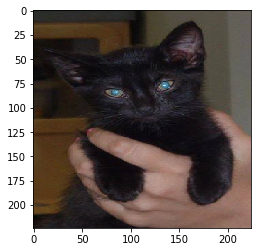

[[('n03788365', 'mosquito_net', 0.04473049), ('n15075141', 'toilet_tissue', 0.042010203), ('n04209239', 'shower_curtain', 0.020713547)]]


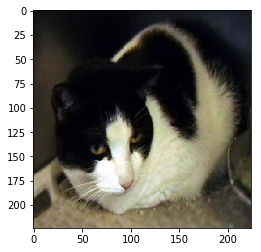

[[('n03788365', 'mosquito_net', 0.05657719), ('n15075141', 'toilet_tissue', 0.02444868), ('n04209239', 'shower_curtain', 0.018866295)]]


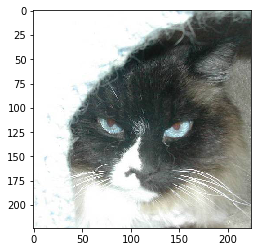

[[('n03788365', 'mosquito_net', 0.06966479), ('n15075141', 'toilet_tissue', 0.023291284), ('n04209239', 'shower_curtain', 0.018162489)]]


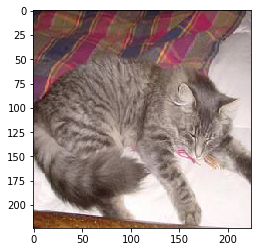

[[('n03788365', 'mosquito_net', 0.15513742), ('n15075141', 'toilet_tissue', 0.038476862), ('n04209239', 'shower_curtain', 0.021815201)]]


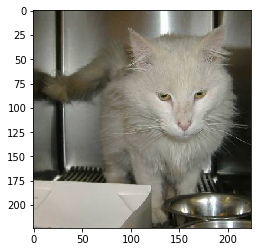

[[('n03788365', 'mosquito_net', 0.16041227), ('n04209239', 'shower_curtain', 0.04541233), ('n15075141', 'toilet_tissue', 0.03158622)]]


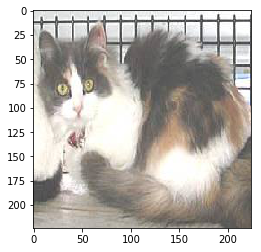

[[('n03788365', 'mosquito_net', 0.11168011), ('n04209239', 'shower_curtain', 0.02840859), ('n15075141', 'toilet_tissue', 0.021412607)]]


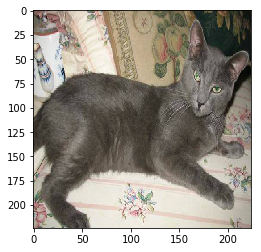

[[('n03788365', 'mosquito_net', 0.18380678), ('n15075141', 'toilet_tissue', 0.046239104), ('n04209239', 'shower_curtain', 0.028388027)]]


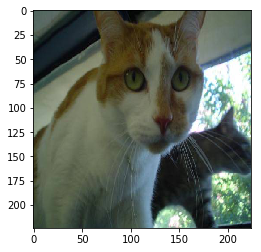

[[('n03788365', 'mosquito_net', 0.22864656), ('n04209239', 'shower_curtain', 0.04108291), ('n15075141', 'toilet_tissue', 0.02796514)]]


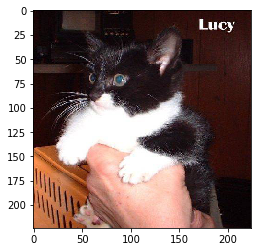

[[('n03788365', 'mosquito_net', 0.12303643), ('n04209239', 'shower_curtain', 0.029219143), ('n15075141', 'toilet_tissue', 0.026167914)]]


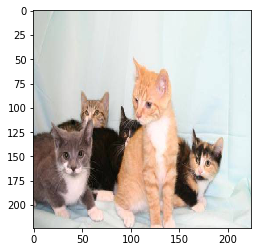

[[('n03788365', 'mosquito_net', 0.13042574), ('n15075141', 'toilet_tissue', 0.041757595), ('n04209239', 'shower_curtain', 0.036011804)]]


In [10]:
for sample in batch[0]:
    plt.imshow(sample)
    predictions = vgg.predict(np.array([sample]))
    labels = decode_predictions(predictions, top=3)
    plt.show()
    print(labels)

In [11]:
vgg.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [12]:
vgg.output

<tf.Tensor 'predictions/Softmax:0' shape=(?, 1000) dtype=float32>

In [13]:
vgg.get_layer('flatten').input

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [14]:
vgg.get_layer('flatten').output

<tf.Tensor 'flatten/Reshape:0' shape=(?, ?) dtype=float32>

In [15]:
base_tensor = vgg.get_layer('flatten').output

tensor = Dense(2014, activation='relu')(base_tensor)
tensor = Dropout(0.2)(tensor)
tensor = Dense(256, activation='relu')(tensor)
tensor = Dropout(0.2)(tensor)
tensor = Dense(1, activation='sigmoid')(tensor)

In [16]:
model = Model(inputs=vgg.input, outputs=tensor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
for i, layer in enumerate(model.layers):
    if i < 19:
        layer.trainable = False
    else:
        layer.trainable = True
    print(i, layer, layer.trainable)

0 <keras.engine.topology.InputLayer object at 0x7f358621b128> False
1 <keras.layers.convolutional.Conv2D object at 0x7f358621b438> False
2 <keras.layers.convolutional.Conv2D object at 0x7f358621b4a8> False
3 <keras.layers.pooling.MaxPooling2D object at 0x7f358621b208> False
4 <keras.layers.convolutional.Conv2D object at 0x7f3498edef60> False
5 <keras.layers.convolutional.Conv2D object at 0x7f3498ef64a8> False
6 <keras.layers.pooling.MaxPooling2D object at 0x7f3498673f98> False
7 <keras.layers.convolutional.Conv2D object at 0x7f3498670588> False
8 <keras.layers.convolutional.Conv2D object at 0x7f3498629a90> False
9 <keras.layers.convolutional.Conv2D object at 0x7f3498649c88> False
10 <keras.layers.pooling.MaxPooling2D object at 0x7f34e8fc5d68> False
11 <keras.layers.convolutional.Conv2D object at 0x7f34e8fdde80> False
12 <keras.layers.convolutional.Conv2D object at 0x7f34e8fed198> False
13 <keras.layers.convolutional.Conv2D object at 0x7f34e8f83e80> False
14 <keras.layers.pooling.MaxPoo

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
opt = optimizers.SGD(lr=0.001)

parallel_model = multi_gpu_model(model, 4)
parallel_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [20]:
train_batches_per_epoch = int(train_generator.samples / train_generator.batch_size) * 2
validation_batches_per_epoch = int(validation_generator.samples / validation_generator.batch_size)
train_batches_per_epoch, validation_batches_per_epoch

(1092, 234)

In [20]:
history = parallel_model.fit_generator(
        train_generator,
        steps_per_epoch=train_batches_per_epoch,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_batches_per_epoch,
        workers=32,
        use_multiprocessing=True)

Epoch 1/10
1092/1092 [==============================] - 221s 202ms/step - loss: 0.4154 - acc: 0.8088 - val_loss: 0.2653 - val_acc: 0.8917
Epoch 2/10
1092/1092 [==============================] - 218s 200ms/step - loss: 0.2995 - acc: 0.8705 - val_loss: 0.2522 - val_acc: 0.8921
Epoch 3/10
1092/1092 [==============================] - 218s 200ms/step - loss: 0.2647 - acc: 0.8887 - val_loss: 0.2133 - val_acc: 0.9093
Epoch 4/10
1092/1092 [==============================] - 218s 200ms/step - loss: 0.2451 - acc: 0.8964 - val_loss: 0.2086 - val_acc: 0.9108
Epoch 5/10
1092/1092 [==============================] - 219s 200ms/step - loss: 0.2305 - acc: 0.9035 - val_loss: 0.1992 - val_acc: 0.9160
Epoch 6/10
1092/1092 [==============================] - 218s 200ms/step - loss: 0.2225 - acc: 0.9069 - val_loss: 0.1854 - val_acc: 0.9231
Epoch 7/10
1092/1092 [==============================] - 218s 200ms/step - loss: 0.2155 - acc: 0.9099 - val_loss: 0.2086 - val_acc: 0.9109
Epoch 8/10
1092/1092 [============

In [22]:
model.save('dogs-cats.h5')

In [21]:
!ls

cars_multivariate.csv  project-01.ipynb  project-05.ipynb  project-09.ipynb
dogs-cats.h5	       project-02.ipynb  project-06.ipynb  splitter.py
kaggle		       project-03.ipynb  project-07.ipynb  tc_bmi.csv
log.txt		       project-04.ipynb  project-08.ipynb


In [23]:
model = load_model('dogs-cats.h5')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
for i, layer in enumerate(model.layers):
    if i < 7:
        layer.trainable = False
    else:
        layer.trainable = True
    print(i, layer, layer.trainable)

0 <keras.engine.topology.InputLayer object at 0x7f33f43b3b38> False
1 <keras.layers.convolutional.Conv2D object at 0x7f33f43b3a58> False
2 <keras.layers.convolutional.Conv2D object at 0x7f33f43b39e8> False
3 <keras.layers.pooling.MaxPooling2D object at 0x7f33f439e668> False
4 <keras.layers.convolutional.Conv2D object at 0x7f33f439e7f0> False
5 <keras.layers.convolutional.Conv2D object at 0x7f33f439ef60> False
6 <keras.layers.pooling.MaxPooling2D object at 0x7f33f439e5f8> False
7 <keras.layers.convolutional.Conv2D object at 0x7f33f439edd8> True
8 <keras.layers.convolutional.Conv2D object at 0x7f33f439eac8> True
9 <keras.layers.convolutional.Conv2D object at 0x7f33f439e710> True
10 <keras.layers.pooling.MaxPooling2D object at 0x7f33f439e240> True
11 <keras.layers.convolutional.Conv2D object at 0x7f33f439e320> True
12 <keras.layers.convolutional.Conv2D object at 0x7f33f439e4a8> True
13 <keras.layers.convolutional.Conv2D object at 0x7f33f43b3240> True
14 <keras.layers.pooling.MaxPooling2D 

In [28]:
# slower training
opt = optimizers.SGD(lr=0.0001)

parallel_model = multi_gpu_model(model, 4)
parallel_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_8 (

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [30]:
history = parallel_model.fit_generator(
        train_generator,
        steps_per_epoch=train_batches_per_epoch,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_batches_per_epoch,
        workers=32,
        use_multiprocessing=True)

Epoch 1/10
1092/1092 [==============================] - 223s 204ms/step - loss: 0.1415 - acc: 0.9422 - val_loss: 0.1270 - val_acc: 0.9493
Epoch 2/10
1092/1092 [==============================] - 220s 202ms/step - loss: 0.1088 - acc: 0.9564 - val_loss: 0.0909 - val_acc: 0.9654
Epoch 3/10
1092/1092 [==============================] - 219s 200ms/step - loss: 0.0922 - acc: 0.9629 - val_loss: 0.0809 - val_acc: 0.9690
Epoch 4/10
1092/1092 [==============================] - 219s 201ms/step - loss: 0.0826 - acc: 0.9669 - val_loss: 0.0749 - val_acc: 0.9720
Epoch 5/10
1092/1092 [==============================] - 220s 201ms/step - loss: 0.0757 - acc: 0.9704 - val_loss: 0.0742 - val_acc: 0.9709
Epoch 6/10
1092/1092 [==============================] - 219s 201ms/step - loss: 0.0735 - acc: 0.9717 - val_loss: 0.0678 - val_acc: 0.9744
Epoch 7/10
1092/1092 [==============================] - 217s 198ms/step - loss: 0.0660 - acc: 0.9741 - val_loss: 0.0653 - val_acc: 0.9757
Epoch 8/10
1092/1092 [============

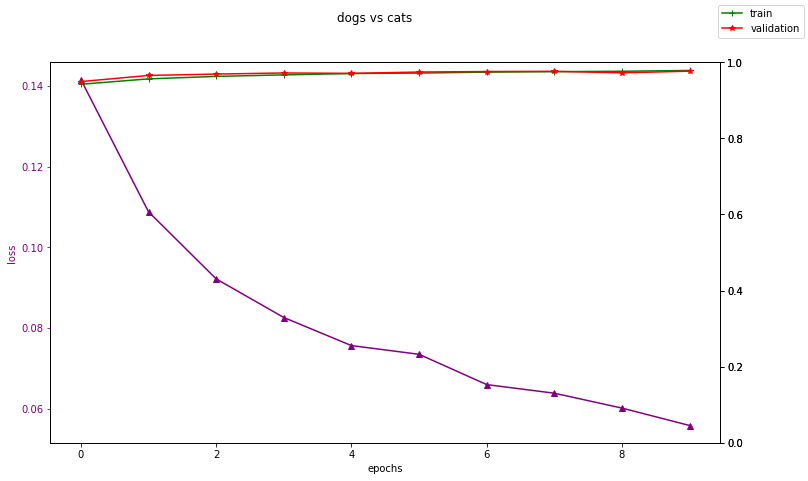

In [31]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(history.epoch, history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(history.epoch, history.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(history.epoch, history.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)

fig.suptitle('dogs vs cats');
fig.legend();

In [32]:
# gettng y and y_hat
probabilities = model.predict_generator(validation_generator, workers=32, use_multiprocessing=True)
y_hat = probabilities > 0.5
y = validation_generator.classes

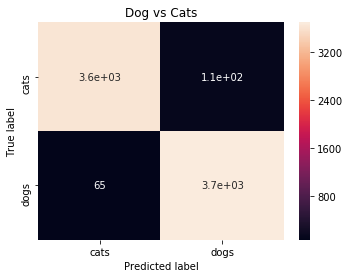

In [33]:
# confusion matrix
klasses = validation_generator.class_indices.keys()
cm = confusion_matrix(y, y_hat)
cm_df = pd.DataFrame(cm,
                     index = klasses, 
                     columns = klasses)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Dog vs Cats')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()